In [2]:
class FormatCleaner():
    def __init__(self, dollar_columns,typo_columns):
        self.dollar_columns=dollar_columns
        self.typo_columns=typo_columns
        pass
    
    def clean(self, X):
        X = deepcopy(X)
        X = (X.pipe(dollar_column, dollar_columns)
                .pipe(typo_column, typo_columns)
               )
        return X
    
    def fit_transform(self, X):
        return self.clean(X)

class Transformer():
    def __init__(self, categorical_columns, drop_columns):
        self.drop_columns =  drop_columns
        self.features = []
        self.categorical_columns = categorical_columns
        pass
    
    def fit_transform(self, X) :
        X.drop(self.drop_columns, axis=1,inplace=True)
        X = pd.get_dummies(X, columns =self.categorical_columns, drop_first=True)       
        self.features = X.columns.values
        return X
    
    def transform(self, X):
        X.drop(self.drop_columns, axis=1,inplace=True)
        X = pd.get_dummies(X, columns =self.categorical_columns, drop_first=True) 
        X = X.reindex(columns = self.features, fill_value=0)
        return X
    



In [3]:
def plot_heatmap(inter):
    sns.set(font_scale=1.5) 
    f, ax = plt.subplots(figsize=(30,2))
    ax = sns.heatmap(inter, vmin=0, vmax=100, annot=True, fmt='.1f')

In [4]:
import os
import sys
sys.path.append(".")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score,recall_score, classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,Normalizer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from importlib import reload
pd.set_option('display.max_columns', 30) 
import seaborn as sns
#import utils
#reload(utils)
#from utils import *

In [5]:
class Preprocessor():
    def __init__(self, dollar_columns, typo_columns, categorical_columns, drop_columns):
        self.cleaner =  FormatCleaner(dollar_columns,dollar_columns)
        self.imputer= SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.transformer=Transformer(categorical_columns=categorical_columns, drop_columns=drop_columns )
        self.scaler= MinMaxScaler()
        self.normalizer =Normalizer()
        self.features = []

        pass
    
    def fit_transform(self, X):
        X= self.cleaner.fit_transform(X)
        print(X.columns)
        print(X.head())
        cols = X.columns.values
        X_imputed = self.imputer.fit_transform(X.values)
        X = self.transformer.fit_transform(pd.DataFrame(X_imputed, columns=cols))
        self.features = self.transformer.features

        X = self.scaler.fit_transform(X.values)
        X = self.normalizer.fit_transform(X)
        return X
    
    
    def transform(self, X):
        X = self.cleaner.fit_transform(X)
        X_imputed = self.imputer.transform(X.values)
        cols = X.columns.values
        X = self.transformer.transform(pd.DataFrame(X_imputed, columns=cols))
        print(self.features)
        X = self.scaler.transform(X.values)
        X = self.normalizer.transform(X)
        return X
        
        
    

In [6]:
def load_data(data_filename):
    """load data set from .csv file as a pd.DataFrame object"""
    data_directory = os.getcwd()
    path=os.path.join(data_directory, "data",data_filename)
    df = pd.read_csv(path)
    print("Data loaded from ", path)
    return df

In [7]:
def description(x):
    t = type(x[0])
    levels = list(x.value_counts().index)
    nbr_levels = len(levels)
    if nbr_levels > 20 : 
        print(f" --- {x.name} --- :{t} | {nbr_levels} \n", *levels[:10], sep=' | ')
        return {"t":t,"nbr_levels":nbr_levels, "levels":levels[:10]}
        
    else:
        print(f" --- {x.name} --- :{t} | {nbr_levels} \n", *levels, sep=' | ')
        return {"t":t,"nbr_levels":nbr_levels, "levels":levels}
def check_na(df, column):
    return pd.DataFrame(df[column].isna().value_counts(normalize=True)*100).T
def dollar_column(df, column):
    df[column] = df[column].replace({'\$': '', '[,]': ''}, regex=True).astype(float)
    return df

def typo_column(df, column):
    df[column] = df[column].apply(lambda x:x.str.lower().replace({'<':'', 
                                                  '/':' ',
                                                  " ":"_",
                                                  'z_':'',
                                                 }, regex=True))
    return df

In [84]:
import pickle
def save_(obj, filename):
    pickle.dump(obj, open(filename, 'wb'))
    
def load_(filename):
    return pickle.load(open(filename, 'rb'))

# PLAN

- Overall Strategy :
    - 0 FAST DESCRIPTIOIN
        - inspect Duplicates
        - inspect NA
        - Value types and levels for format
        - Conclude with cleaning steps
    - 0 Data Cleaning
        - Missing values
        - String misspelled
        - Dollars to float
    - 0 Exploratory data anaylsis
        - General data content descritption
        - Distribution of data by label "TARGET_FLAG"
    - 1 Data Processing pipeline :
        - NA imputation
            - Imputation by mode
        - Cleaning
        - Scaling
        - Normalisation
    - 2 Metric choice
        - Recall
    - 3 Benchmark model
        - Dummy models
    - 4 Most important features by Random Forest
        - Feature selection
    - 5 Trying different models that are fit for the binary classification problem:
        - Ensemble Methods
        - Naive Bayes classifier
        - 
    - 6 Final model discuss
    

In [8]:
TRAIN_FILENAME = "train_auto.csv"
TEST_FILENAME = "test_auto.csv"

In [9]:
df = load_data(TRAIN_FILENAME)

Data loaded from  /Users/sarahelbeji/Documents/projects/4_jobInterviews/descartes_underwriting/data/train_auto.csv


# Fast description on train set

In [10]:
# duplicated
df.duplicated().any()

False

--- Columns with NA values :  | AGE | YOJ | INCOME | HOME_VAL | JOB | CAR_AGE


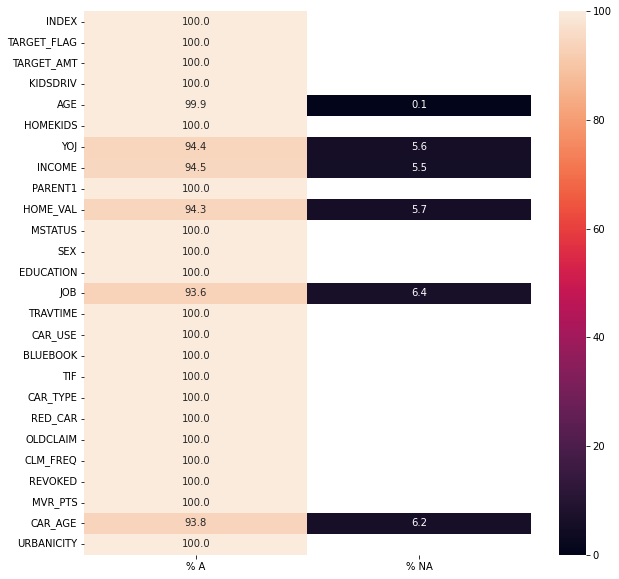

In [11]:
# NA values
inter = df.apply(lambda x:(x.isna().value_counts(normalize=True))*100).T.rename(columns={True:'% NA', False:'% A'})                                                          
f, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(inter, vmin=0, vmax=100, annot=True, fmt='.1f')
print("--- Columns with NA values : ",  *inter[inter["% NA"] > 0].index, sep=" | ")

In [12]:
#Value types and levels for format 
dict_description ={}
df.apply(lambda x: dict_description.setdefault(x.name,description(x)))

 --- INDEX --- :<class 'numpy.int64'> | 8161 
 | 1 | 6874 | 6890 | 6889 | 6888 | 6887 | 6886 | 6884 | 6883 | 6882
 --- TARGET_FLAG --- :<class 'numpy.int64'> | 2 
 | 0 | 1
 --- TARGET_AMT --- :<class 'numpy.float64'> | 1949 
 | 0.0 | 2327.0 | 3350.0 | 980.0 | 3667.0 | 2489.0 | 2493.0 | 5453.0 | 3501.0 | 5728.0
 --- KIDSDRIV --- :<class 'numpy.int64'> | 5 
 | 0 | 1 | 2 | 3 | 4
 --- AGE --- :<class 'numpy.float64'> | 60 
 | 46.0 | 45.0 | 48.0 | 47.0 | 43.0 | 41.0 | 44.0 | 42.0 | 50.0 | 40.0
 --- HOMEKIDS --- :<class 'numpy.int64'> | 6 
 | 0 | 2 | 1 | 3 | 4 | 5
 --- YOJ --- :<class 'numpy.float64'> | 21 
 | 12.0 | 13.0 | 11.0 | 14.0 | 10.0 | 0.0 | 9.0 | 15.0 | 8.0 | 7.0
 --- INCOME --- :<class 'str'> | 6612 
 | $0 | $61,790 | $48,509 | $26,840 | $158 | $80,183 | $20,887 | $65,885 | $23,157 | $64,032
 --- PARENT1 --- :<class 'str'> | 2 
 | No | Yes
 --- HOME_VAL --- :<class 'str'> | 5106 
 | $0 | $238,724 | $196,320 | $332,673 | $123,109 | $153,061 | $173,130 | $115,249 | $159,568 | $288,5

INDEX          {'t': <class 'numpy.int64'>, 'nbr_levels': 816...
TARGET_FLAG    {'t': <class 'numpy.int64'>, 'nbr_levels': 2, ...
TARGET_AMT     {'t': <class 'numpy.float64'>, 'nbr_levels': 1...
KIDSDRIV       {'t': <class 'numpy.int64'>, 'nbr_levels': 5, ...
AGE            {'t': <class 'numpy.float64'>, 'nbr_levels': 6...
HOMEKIDS       {'t': <class 'numpy.int64'>, 'nbr_levels': 6, ...
YOJ            {'t': <class 'numpy.float64'>, 'nbr_levels': 2...
INCOME         {'t': <class 'str'>, 'nbr_levels': 6612, 'leve...
PARENT1        {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
HOME_VAL       {'t': <class 'str'>, 'nbr_levels': 5106, 'leve...
MSTATUS        {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
SEX            {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
EDUCATION      {'t': <class 'str'>, 'nbr_levels': 5, 'levels'...
JOB            {'t': <class 'str'>, 'nbr_levels': 8, 'levels'...
TRAVTIME       {'t': <class 'numpy.int64'>, 'nbr_levels': 97,...
CAR_USE        {'t': <cla

In [13]:
# data shape
df.shape

(8161, 26)

 ### Conclusion : observations and schema for cleaning

- The train dataset has 26 columns and 8161 records.
- <b>Format cleaning : 14 unclean, 12 clean</b> : 
    - 4 columns (INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM) 
    - 10 columns (PARENT1, MSTATUS, SEX, CAR_TYPE, JOB, CAR_USE, RED_CAR, REVOKED, URBANICITY, EDUCATION) are encoded as string with unclean values (ex : 'z_No' for 'No', 'z_F' for 'F')

- 7 columns (PARENT1, MSTATUS, SEX, CAR_USE, RED_CAR, REVOKED, URBANICITY):
    - should be cleaned and changed to binary (they can be kept also as categorical : some models need this change, others handle it automatically. Best way is to change it anyway to suit all potential models).

- 2 columns (JOB, EDUCATION) are muli-class (>2) categorical :
    - encoded with unclean string values (ex : "z_SUV" for "suv")
    - certain values englobe other values or are the same but encoded as two levels :
        - JOB : Professional , Manager, Lawyer , Doctor as different levels when {Manager, Lawyer , Doctor} is included in Professional. 
        - EDUCATION :  has two levels z_High School,  <High School when they both refer to the sam elvel of education. 
    - EDUCATION : can be encoded ordinal since there is can be a ranking of education level.
        

# Data Cleaning

In [14]:
import regex as re
from copy import deepcopy

In [15]:
# cleaning typos and logical input
dollar_columns = ['HOME_VAL','INCOME','BLUEBOOK','OLDCLAIM']
typo_columns =['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY','CAR_TYPE','JOB','EDUCATION']

# changing types
cat_to_binary = ['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY']
categorical_to_ordinal =['EDUCATION']

### format cleaning

In [16]:
df_clean = deepcopy(df)
df_clean = (df_clean.pipe(dollar_column, dollar_columns)
            .pipe(typo_column, typo_columns)
           )

In [17]:
# check cleaning result
dict_description_description = {}
df_clean.apply(lambda x: dict_description_description.setdefault(x.name,description(x)))

 --- INDEX --- :<class 'numpy.int64'> | 8161 
 | 1 | 6874 | 6890 | 6889 | 6888 | 6887 | 6886 | 6884 | 6883 | 6882
 --- TARGET_FLAG --- :<class 'numpy.int64'> | 2 
 | 0 | 1
 --- TARGET_AMT --- :<class 'numpy.float64'> | 1949 
 | 0.0 | 2327.0 | 3350.0 | 980.0 | 3667.0 | 2489.0 | 2493.0 | 5453.0 | 3501.0 | 5728.0
 --- KIDSDRIV --- :<class 'numpy.int64'> | 5 
 | 0 | 1 | 2 | 3 | 4
 --- AGE --- :<class 'numpy.float64'> | 60 
 | 46.0 | 45.0 | 48.0 | 47.0 | 43.0 | 41.0 | 44.0 | 42.0 | 50.0 | 40.0
 --- HOMEKIDS --- :<class 'numpy.int64'> | 6 
 | 0 | 2 | 1 | 3 | 4 | 5
 --- YOJ --- :<class 'numpy.float64'> | 21 
 | 12.0 | 13.0 | 11.0 | 14.0 | 10.0 | 0.0 | 9.0 | 15.0 | 8.0 | 7.0
 --- INCOME --- :<class 'numpy.float64'> | 6612 
 | 0.0 | 61790.0 | 48509.0 | 26840.0 | 158.0 | 80183.0 | 20887.0 | 65885.0 | 23157.0 | 64032.0
 --- PARENT1 --- :<class 'str'> | 2 
 | no | yes
 --- HOME_VAL --- :<class 'numpy.float64'> | 5106 
 | 0.0 | 238724.0 | 196320.0 | 332673.0 | 123109.0 | 153061.0 | 173130.0 | 11524

INDEX          {'t': <class 'numpy.int64'>, 'nbr_levels': 816...
TARGET_FLAG    {'t': <class 'numpy.int64'>, 'nbr_levels': 2, ...
TARGET_AMT     {'t': <class 'numpy.float64'>, 'nbr_levels': 1...
KIDSDRIV       {'t': <class 'numpy.int64'>, 'nbr_levels': 5, ...
AGE            {'t': <class 'numpy.float64'>, 'nbr_levels': 6...
HOMEKIDS       {'t': <class 'numpy.int64'>, 'nbr_levels': 6, ...
YOJ            {'t': <class 'numpy.float64'>, 'nbr_levels': 2...
INCOME         {'t': <class 'numpy.float64'>, 'nbr_levels': 6...
PARENT1        {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
HOME_VAL       {'t': <class 'numpy.float64'>, 'nbr_levels': 5...
MSTATUS        {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
SEX            {'t': <class 'str'>, 'nbr_levels': 2, 'levels'...
EDUCATION      {'t': <class 'str'>, 'nbr_levels': 4, 'levels'...
JOB            {'t': <class 'str'>, 'nbr_levels': 8, 'levels'...
TRAVTIME       {'t': <class 'numpy.int64'>, 'nbr_levels': 97,...
CAR_USE        {'t': <cla

# Exploratory data analysis

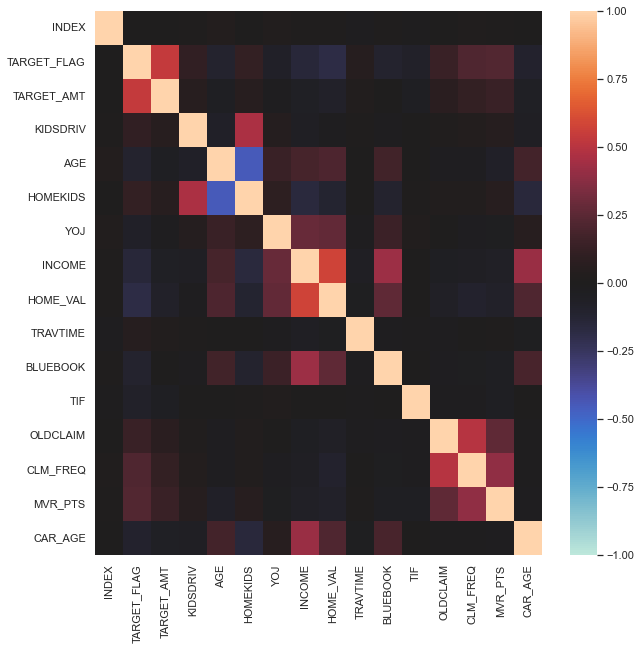

In [18]:
# look if correlation would be a problem
sns.set(rc = {'figure.figsize':(10,10)})
corrMatrix = df_clean.corr()
sns.heatmap(corrMatrix,
           vmin=-1, vmax=1,
           annot=False, center=0)
plt.show()

### Observation and conclusion on next steps :

- The follwing relations will be investigated because of high correlation level (>~0.2 in abs):
    - TARGET_FLAG and TARGET_AMT are very correlated. ACtually, TARGET_FLAG is an immediate flag for class 0. it will be dropped.
    - KIDSDRIV and YOJ
    - HOMEKIDS and AGE
    - YOJ and INCOME
    - YOJ and HOME_VAL
    - INCOME and BLUEBOOK
    - HOME_VAL and BLUEBOOK
    - OLD_CLAIM and CLM_FREQ and MVR_PTS


## Distributions of data

In [19]:
columns = list(df.columns)
columns.sort()

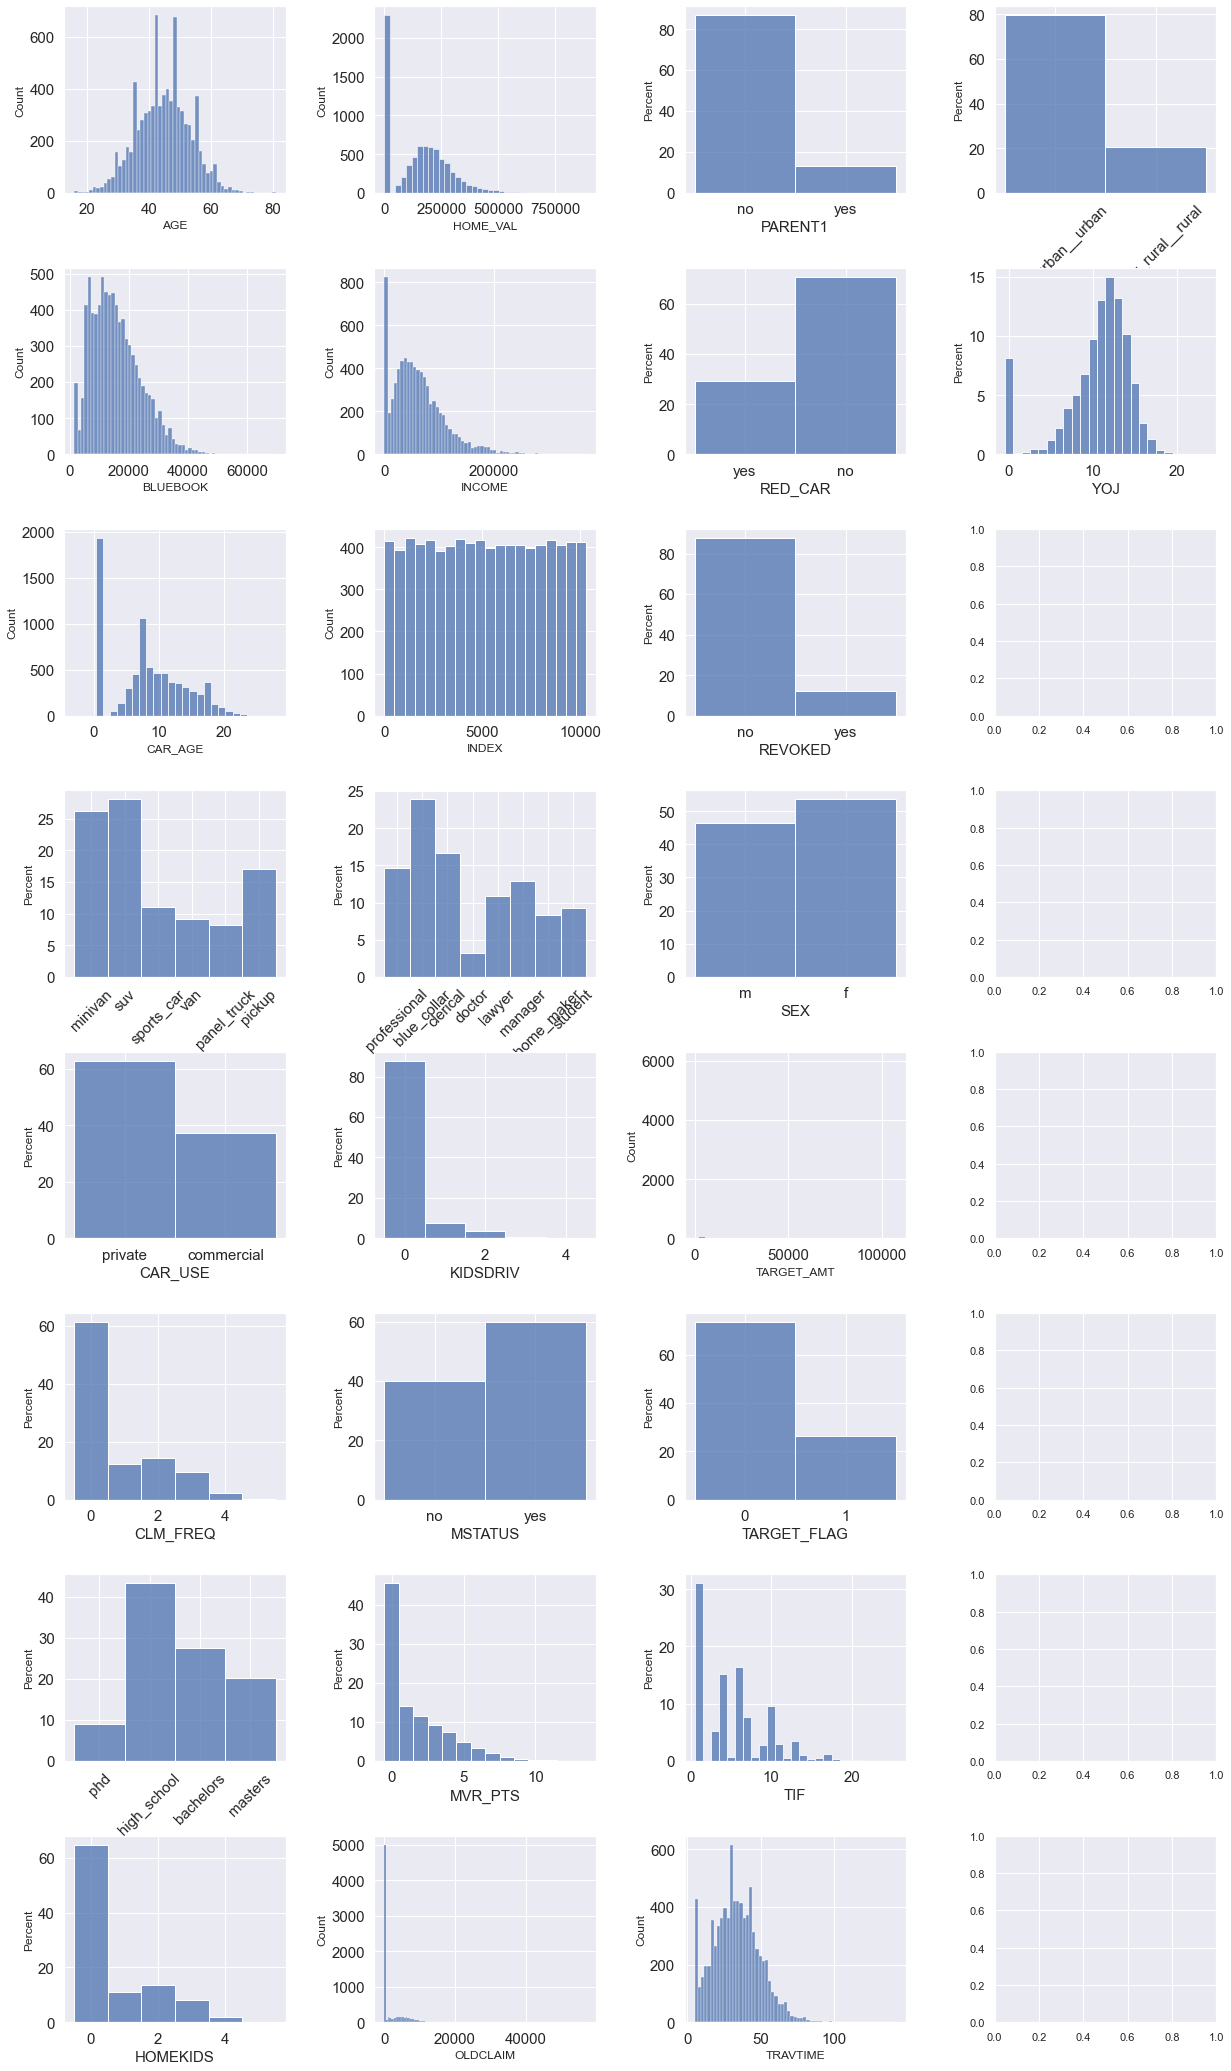

In [20]:
x,y= 8, 26//8+1
fig, axes = plt.subplots(x,y, sharex=False, figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)
fs =15
for j in range(y):
    for i in range(x):
        if i+j*8 > 25 :
            break
        else:
            column = columns[i+j*8]
            sns.set(font_scale=1) 
            if dict_description_description[column]['nbr_levels'] <30 :
                sns.histplot(data=df_clean, ax= axes[i][j],x=column, multiple="dodge",stat="percent", common_norm=True, palette="husl",discrete=True )
                axes[i][j].set_xlabel(column, fontsize = fs)


            else :
                sns.histplot(data=df_clean, ax= axes[i][j],x=column ,palette="husl")
                #axes[i][j].set_xlabel("TARGET_FLAG", fontsize = fs)
            axes[i][j].tick_params(labelsize=fs)
            
            if column in ['JOB','CAR_TYPE','URBANICITY','EDUCATION'] :
                axes[i][j].tick_params(axis='x', rotation=45)

### Observation on dataset and next steps:

    - Dataset unbalanced (less than 30% have TARGET_FLAG = 1).
    - Many covariates are have skewed distributions. We can handle them in modeling using different strategies like Box Cox transformation or log-transformation, or scaling and normalization. We will use scaling and normalization in next steps.
    - 'INDEX' is not useful, we will drop it.
    - Many features have many records equal to 0 (CAR_AGE, CLAIM_FREQ, HOMEKIDS (no kids), HOME_VAL (no home, rental ? we can add an engineered feature "home owner"), INCOME (no job), KIDSDRIV (no kids), YOJ (no job).

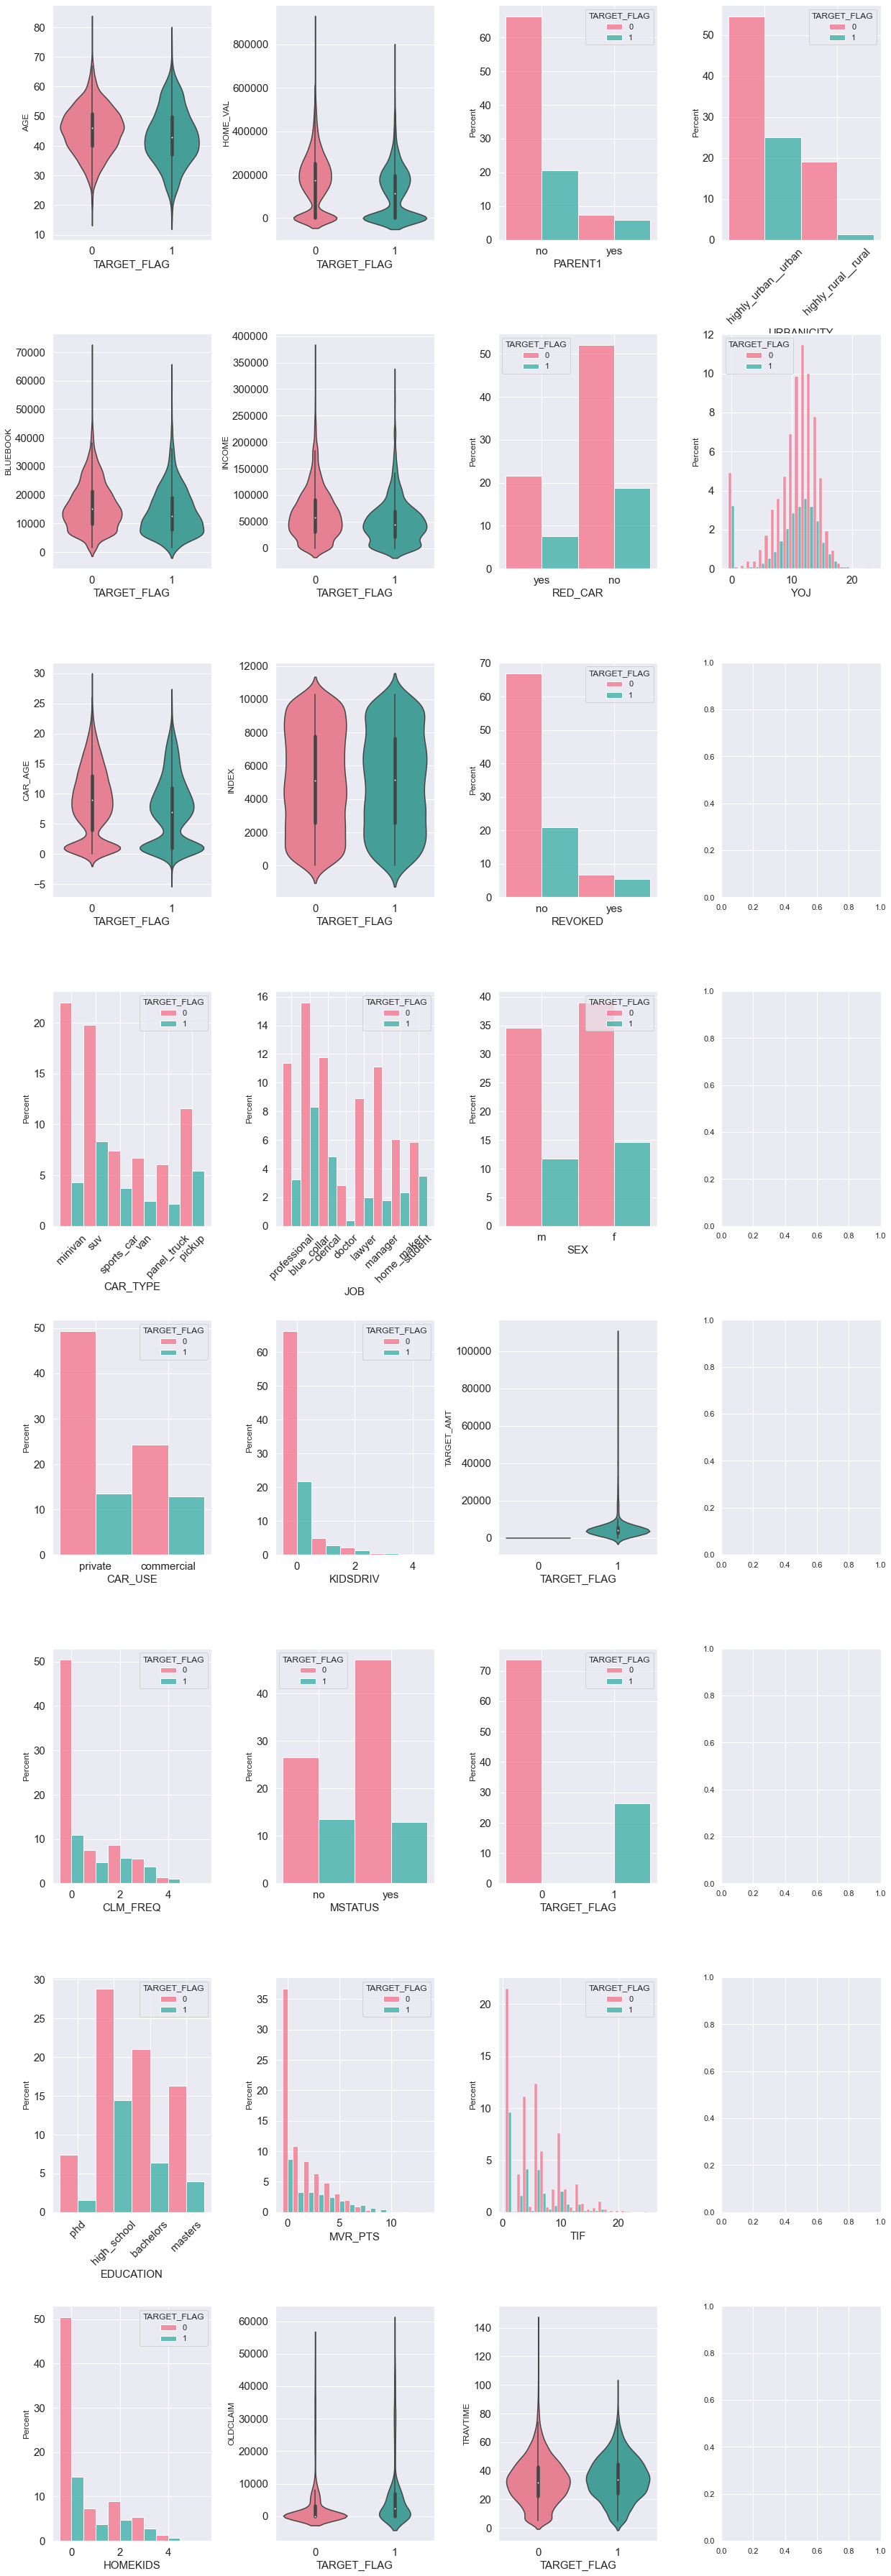

In [21]:
x,y= 8, 26//8+1
fig, axes = plt.subplots(x,y, sharex=False, figsize=(20,35))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)
fs =15

for j in range(y):
    for i in range(x):
        if i+j*8 > 25 :
            break
        else:
            column = columns[i+j*8]
            sns.set(font_scale=1) 
            if dict_description_description[column]['nbr_levels'] <30 :
                sns.histplot(data=df_clean, ax= axes[i][j],x=column, hue="TARGET_FLAG", multiple="dodge",stat="percent", common_norm=True, palette="husl",discrete=True )
                axes[i][j].set_xlabel(column, fontsize = fs)


            else :
                sns.violinplot(data=df_clean, ax= axes[i][j],y=column,
                             x="TARGET_FLAG", 
                            palette="husl", )
                axes[i][j].set_xlabel("TARGET_FLAG", fontsize = fs)
            axes[i][j].tick_params(labelsize=fs)
            
            if column in ['JOB','CAR_TYPE','URBANICITY','EDUCATION'] :
                axes[i][j].tick_params(axis='x', rotation=45)

            

### Observation on data distribution on average by "TARGET_FLAG" level :
- ~ On average, crashes happen more for policyholders with :
    - lower AGE value (younger drivers)
    - younger cars. Which could reflect in a manner the experience of the driver. 
    - higher TRAVTIME
    - lower home values.
- crashes are more frequent amongst:
    - urban areas

In the next step, we prepare data according to steps discussed above.

# Further processing

### Discussing data imputation

In [22]:
impute_cols =list(df_clean.columns[df_clean.isnull().any()])
impute_vals = df_clean[impute_cols].values
print(' --- columns to impute  :', *impute_cols, sep="  |  ")

 --- columns to impute  :  |  AGE  |  YOJ  |  INCOME  |  HOME_VAL  |  JOB  |  CAR_AGE


In [23]:
import numpy as np
from sklearn.impute import SimpleImputer

#impute with most frequent for discrete
mf_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X = mf_imputer.fit_transform(impute_vals)
new_df = pd.DataFrame(X, columns=impute_cols)

In [24]:
combined = pd.concat([df_clean, new_df], keys=['original', 'mode_imputation'], axis=0).reset_index().rename(columns={'level_0':"imputer"})

AGE
YOJ
INCOME
HOME_VAL
JOB
CAR_AGE


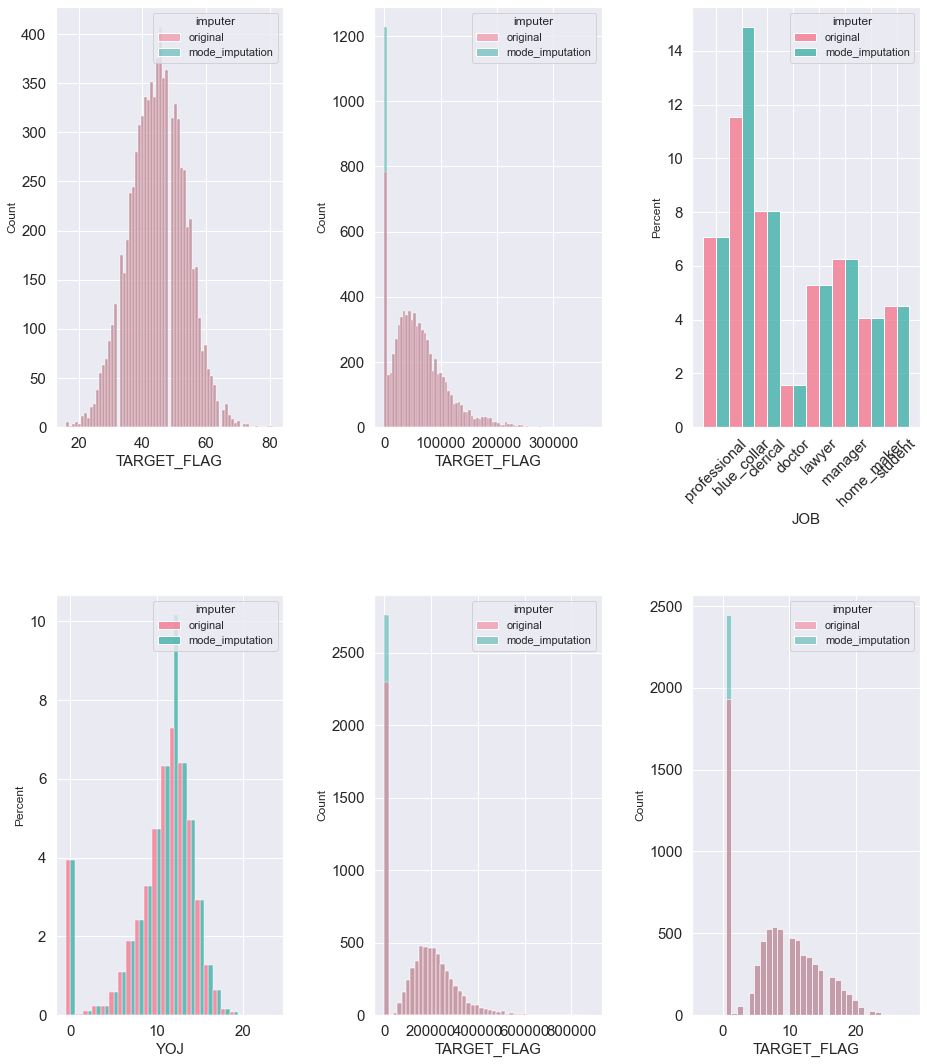

In [25]:
x,y= 2, 3
fig, axes = plt.subplots(x,y, sharex=False, figsize=(15,10))
plt.subplots_adjust(left=0.1,bottom=0.1,top=1.5,wspace=0.4,hspace=0.4)

fs=15
for j in range(y):
    for i in range(x):
        column = impute_cols[j*2+i]
        print(column)
        sns.set(font_scale=1) 
        if dict_description_description[column]['nbr_levels'] <30 :
            sns.histplot(data=combined, ax= axes[i][j], x=column, multiple="dodge", hue="imputer", stat="percent", common_norm=True, palette="husl", discrete=True )
            axes[i][j].set_xlabel(column, fontsize = fs)

        else :
            sns.histplot(data=combined, ax= axes[i][j], x=column, hue="imputer" ,palette="husl")
            axes[i][j].set_xlabel("TARGET_FLAG", fontsize = fs)
        axes[i][j].tick_params(labelsize=fs)

        if column in ['JOB'] :
            axes[i][j].tick_params(axis='x', rotation=45)   

In [26]:
for col in impute_cols:
    df_clean[col] = new_df[col]

### Changing columns to categories

In [27]:
categorical_columns = ['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY','CAR_TYPE','JOB','EDUCATION']

In [28]:
## categorical to dummies
df_clean = pd.get_dummies(df_clean, columns =categorical_columns, drop_first=True)

### drop correlated covariates and index

In [29]:
to_drop = ["TARGET_AMT","INDEX",'TARGET_FLAG']
labels = df_clean['TARGET_FLAG'].values
df_clean.drop(to_drop, axis=1,inplace=True)

In [30]:
df_clean.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME',
       'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE',
       'PARENT1_yes', 'MSTATUS_yes', 'SEX_m', 'CAR_USE_private', 'RED_CAR_yes',
       'REVOKED_yes', 'URBANICITY_highly_urban__urban', 'CAR_TYPE_panel_truck',
       'CAR_TYPE_pickup', 'CAR_TYPE_sports_car', 'CAR_TYPE_suv',
       'CAR_TYPE_van', 'JOB_clerical', 'JOB_doctor', 'JOB_home_maker',
       'JOB_lawyer', 'JOB_manager', 'JOB_professional', 'JOB_student',
       'EDUCATION_high_school', 'EDUCATION_masters', 'EDUCATION_phd'],
      dtype='object')

### All the discussed steps are incorporated in the Preprocessor class, we prepare our data for training.

# Data Processing

In [31]:
from sklearn.pipeline import Pipeline

In [32]:
# load data again from scartch
df = load_data(TRAIN_FILENAME)

Data loaded from  /Users/sarahelbeji/Documents/projects/4_jobInterviews/descartes_underwriting/data/train_auto.csv


In [33]:
from sklearn.model_selection import train_test_split
# we split our data as training and testing : the test set is not touched until the end. where we use it to test 
# best classifier for each model class chosen.

df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [34]:
pr = Preprocessor(dollar_columns, typo_columns, categorical_columns, to_drop)

In [35]:
# check that we well shuffeled (lebel wise)
print(df_train['TARGET_FLAG'].value_counts(normalize=True))
print(df_test['TARGET_FLAG'].value_counts(normalize=True))

0    0.736236
1    0.263764
Name: TARGET_FLAG, dtype: float64
0    0.73608
1    0.26392
Name: TARGET_FLAG, dtype: float64


In [36]:
# get label
y_train = df_train['TARGET_FLAG'].values
y_test = df_test['TARGET_FLAG'].values

In [37]:
# clean test and train set
X_train = pr.fit_transform(df_train)
X_test = pr.transform(df_test)

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')
      INDEX  TARGET_FLAG  TARGET_AMT  KIDSDRIV   AGE  HOMEKIDS   YOJ  \
4778   6024            1      2007.0         0  57.0         0   8.0   
1748   2194            0         0.0         0  46.0         0  15.0   
7358   9303            1      2440.0         0  51.0         0  13.0   
6244   7914            0         0.0         0  49.0         0   0.0   
3296   4158            0         0.0         0  62.0         0  14.0   

        INCOME PARENT1  HOME_VAL MSTATUS SEX    EDUCATION          JOB  \
4778   38253.0      no  208139.0      no   f  high_school      manager   
1748  181918.0      no  411687.0     yes   f          phd       doctor   
7358  14792

# Modelisation and metrics

- This problem is a classifixation problem. We will use binary classfiers. 
- Data is unbalanced. We have 30% of TARGET_FLAG =1 and 70% of TARGET_FLAG=0. If our goal was to flag potentially risky clients, misclassifying a 'problematic' or potentially risky profile driver as okey (for example) would be a problem. So actually, we want to minimize the predicted false negatives : minimize the false negative rate. Thus, we want to maximize the <b>recall</b> which is 1-FNR.

### Use oversampling as a stragtegy to cope with unbalanced data

In [46]:
import imblearn
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 4025), (1, 4025)]


## benchamrk model

We use a benchamark model to see how very naive approches would perform as a benchamrk not to fall under.

In [38]:
def score_classifier(dataset, classifier, labels):
    predicted_labels = classifier.predict(dataset)
    cls_report =classification_report(labels, predicted_labels, zero_division=0)
    print(cls_report)
    return classifier

In [39]:
dummy_1 = DummyClassifier(strategy="uniform").fit(X_train,y_train)
score_classifier(dataset=X_train, classifier=dummy_1, labels=y_train)

              precision    recall  f1-score   support

           0       0.73      0.50      0.59      4025
           1       0.26      0.50      0.34      1442

    accuracy                           0.50      5467
   macro avg       0.50      0.50      0.47      5467
weighted avg       0.61      0.50      0.53      5467



DummyClassifier(strategy='uniform')

In [40]:
dummy_2 = DummyClassifier(strategy="most_frequent").fit(X_train,y_train)
score_classifier(dataset=X_train, classifier=dummy_2, labels=y_train)

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      4025
           1       0.00      0.00      0.00      1442

    accuracy                           0.74      5467
   macro avg       0.37      0.50      0.42      5467
weighted avg       0.54      0.74      0.62      5467



DummyClassifier(strategy='most_frequent')

In [41]:
def perform_RandomSearch(dataset, classifier, labels, params, split_number=3):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """
    
    print("SEARCHING FOR BEST PARAMS\n")
    cross_val = StratifiedKFold(n_splits=split_number)
    index_iterator = cross_val.split(dataset, labels)
    clf = RandomizedSearchCV(estimator=classifier(), 
                             param_distributions=params,
                             random_state=0,
                             cv=cross_val,
                             n_iter=50,
                             scoring="recall",
                             verbose=1)
    search = clf.fit(X=dataset, y=labels)
    best_params=search.best_params_
    print(f"BEST PARAMETERS \n {best_params}")
    
    print("RE-TRAIN BEST MODEL AND EVALUATE \n")
    return search

In [42]:
from sklearn.model_selection import StratifiedKFold

## optimizing models using grid search then train best model using cross-validation

In [45]:
# grid search on random forest 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]+[None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 8, 12, 32]
RF_params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

In [47]:
search_RF = perform_RandomSearch(dataset=X_resampled, classifier=RandomForestClassifier, labels=y_resampled, params=RF_params, split_number=5)

SEARCHING FOR BEST PARAMS

Fitting 5 folds for each of 50 candidates, totalling 250 fits
BEST PARAMETERS 
 {'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
RE-TRAIN BEST MODEL AND EVALUATE 



In [49]:
def kfold_train(X,y, clf, n_splits=10):
    kf = StratifiedKFold(n_splits, shuffle=True)
    kf.get_n_splits(X, y)
    confusion_mat = np.zeros((2,2))
    recall = []
    precision= []
    for train_index, val_index in kf.split(X,y):
        x_train, x_val =  X[train_index], X[val_index]
        y_train, y_val =  y[train_index], y[val_index]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        confusion_mat+=confusion_matrix(y_val,y_pred)
        recall.append(recall_score(y_val,y_pred))
        precision.append(precision_score(y_val,y_pred))
        cls_report =classification_report(y_train, clf.predict(x_train), zero_division=0)
    mean_recall = np.mean(recall, axis=0)
    mean_precision = np.mean(precision, axis=0)
    
    print(f"precision {mean_precision}")
    print(f"recall{mean_recall}")
    return clf, recall, precision

### Ensemble models

### Bagging : Random Forest

In [50]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [51]:
# take best model
model_RF = RandomForestClassifier(**search_RF.best_params_)

# train 
model_RF, recall, precision = kfold_train(X_resampled, y_resampled, clf=model_RF, n_splits=3)

# evaluate 
score_classifier(dataset=X_resampled, 
                            classifier=model_RF,
                            labels=y_resampled)

#evalaute on test set
score_classifier(dataset=X_test, 
                            classifier=model_RF,
                            labels=y_test)

precision 0.8524197785319928
recall0.9185117763619249
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4025
           1       0.95      0.98      0.96      4025

    accuracy                           0.96      8050
   macro avg       0.96      0.96      0.96      8050
weighted avg       0.96      0.96      0.96      8050

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1983
           1       0.57      0.57      0.57       711

    accuracy                           0.77      2694
   macro avg       0.71      0.71      0.71      2694
weighted avg       0.77      0.77      0.77      2694



RandomForestClassifier(max_depth=30, n_estimators=160)

# Feature selection

### Most important features using RF

We use random forest to select best features. Other strategies like PCA could be used. But RF is more intuitive and interpretable as it has an inherent splitting test based on most imporant feature (information gain wise). In the following modelling however we keep all features (faster to code and the models are not that complex and heavy to need feature selection). We could use it to have lighter models but we keep the pipeline simple (time restriction). 

Text(0.5, 0, 'Random Forest Feature Importance')

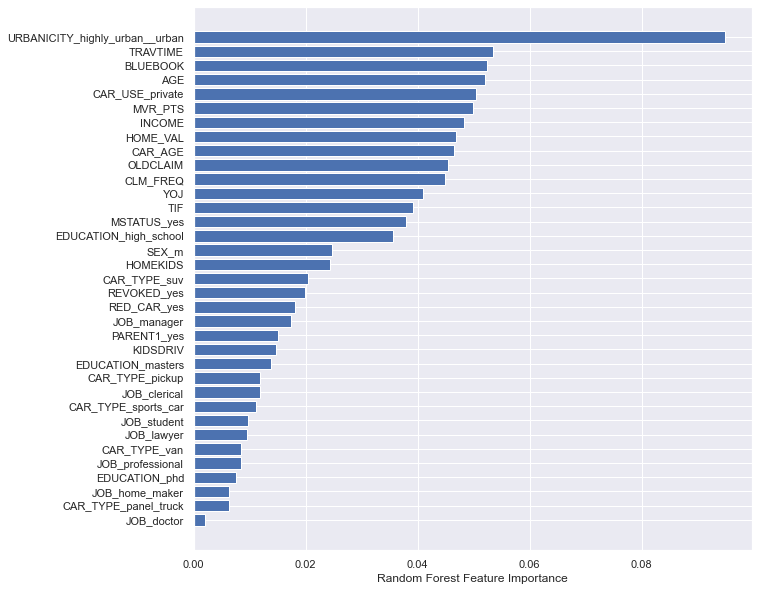

In [69]:
sorted_idx = model_RF.feature_importances_.argsort()
plt.barh(pr.features[sorted_idx], model_RF.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Boosting

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [10,100]
max_depth = [10,]
learning_rate = [0.001, 0.005, 0.01]

grid_Boosting = dict(n_estimators=n_estimators,
                     learning_rate=learning_rate, 
                     max_depth=max_depth)
search_Boosting =perform_RandomSearch(dataset=X_resampled,
                                         classifier=GradientBoostingClassifier,
                                         labels=y_resampled,
                                         params=grid_Boosting)

SEARCHING FOR BEST PARAMS

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


BEST PARAMETERS 
 {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01}
RE-TRAIN BEST MODEL AND EVALUATE 



In [54]:
# take best model
model_Boosting = GradientBoostingClassifier(**search_Boosting.best_params_)

# train again on more validation splits
model_Boosting, recall, precision = kfold_train(X_resampled, y_resampled, clf=model_Boosting, n_splits=10)

# evaluate 
score_classifier(dataset=X_resampled, 
                            classifier=model_Boosting,
                            labels=y_resampled)

#evalaute on test set
score_classifier(dataset=X_test, 
                            classifier=model_Boosting,
                            labels=y_test)

precision 0.8061634014000771
recall0.9195023641099713
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4025
           1       0.92      0.97      0.94      4025

    accuracy                           0.94      8050
   macro avg       0.94      0.94      0.94      8050
weighted avg       0.94      0.94      0.94      8050

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1983
           1       0.50      0.62      0.55       711

    accuracy                           0.74      2694
   macro avg       0.68      0.70      0.68      2694
weighted avg       0.76      0.74      0.74      2694



GradientBoostingClassifier(learning_rate=0.01, max_depth=10)

### Naive Bayes

Gaussian Naive Bayes makes the assumption of normal disctribution and independent variables which thanks to scaling and normalization is respected along with the fact that correlation is not very present in the data. It can thus be suited for classifying our data.

In [65]:
# take best model
model_NB = GaussianNB()

# train again on more validation splits
model_NB, recall, precision = kfold_train(X_resampled, y_resampled, clf=model_NB, n_splits=10)

# evaluate 
score_classifier(dataset=X_resampled, 
                            classifier=model_NB,
                            labels=y_resampled)

#evalaute on test set
score_classifier(dataset=X_test, 
                            classifier=model_NB,
                            labels=y_test)

precision 0.6931612099714357
recall0.7279557547251336
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      4025
           1       0.69      0.73      0.71      4025

    accuracy                           0.70      8050
   macro avg       0.70      0.70      0.70      8050
weighted avg       0.70      0.70      0.70      8050

              precision    recall  f1-score   support

           0       0.87      0.68      0.77      1983
           1       0.45      0.72      0.56       711

    accuracy                           0.69      2694
   macro avg       0.66      0.70      0.66      2694
weighted avg       0.76      0.69      0.71      2694



GaussianNB()

### Logistic Regression

Logistic regression is a binary classfier which is suited to solve our problem : multi collinearity does not seem to be an issue in our data. Although the linear assumption is not realistic in general, the model can still learn perform well.

In [63]:
grid_LR = {"C":np.logspace(-3,1,50),}
search =perform_RandomSearch(dataset=X_resampled,
                                         classifier=LogisticRegression,
                                         labels=y_resampled,
                                         params=grid_LR)


SEARCHING FOR BEST PARAMS

Fitting 3 folds for each of 50 candidates, totalling 150 fits
BEST PARAMETERS 
 {'C': 6.866488450042998}
RE-TRAIN BEST MODEL AND EVALUATE 



In [64]:
# take best model
model_LR = LogisticRegression()

# train again on more validation splits
model_LR, recall, precision = kfold_train(X_resampled, y_resampled, clf=model_LR, n_splits=10)

# evaluate 
score_classifier(dataset=X_resampled, 
                            classifier=model_LR,
                            labels=y_resampled)

#evalaute on test set
score_classifier(dataset=X_test, 
                            classifier=model_LR,
                            labels=y_test)

precision 0.7234627948689833
recall0.7525418811648951
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4025
           1       0.73      0.75      0.74      4025

    accuracy                           0.74      8050
   macro avg       0.74      0.74      0.74      8050
weighted avg       0.74      0.74      0.74      8050

              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1983
           1       0.48      0.73      0.58       711

    accuracy                           0.72      2694
   macro avg       0.68      0.72      0.68      2694
weighted avg       0.77      0.72      0.73      2694



LogisticRegression()

### Support Vector Classifier

is also a binary classfier. SVM do not perform very well for very large datasets. The dataset can be considered relatively small. We hypertune to find the best kernel which is crucial in SVM.

In [66]:
from sklearn.svm import SVC

In [70]:
grid_SVC = {'C':np.logspace(-3,3,50),'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','poly']}
search =perform_RandomSearch(dataset=X_resampled,
                                         classifier=SVC,
                                         labels=y_resampled,
                                         params=grid_SVC)
# take best model
model_SVC = SVC()

# train again on more validation splits
model_SVC, recall, precision = kfold_train(X_resampled, y_resampled, clf=model_SVC, n_splits=10)

# evaluate 
score_classifier(dataset=X_resampled, 
                            classifier=model_SVC,
                            labels=y_resampled)

#evalaute on test set
score_classifier(dataset=X_test, 
                            classifier=model_SVC,
                            labels=y_test)

SEARCHING FOR BEST PARAMS

Fitting 3 folds for each of 50 candidates, totalling 150 fits
BEST PARAMETERS 
 {'kernel': 'poly', 'gamma': 1, 'C': 79.06043210907701}
RE-TRAIN BEST MODEL AND EVALUATE 

precision 0.7398062945582653
recall0.8211053911583521
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      4025
           1       0.77      0.85      0.80      4025

    accuracy                           0.79      8050
   macro avg       0.80      0.79      0.79      8050
weighted avg       0.80      0.79      0.79      8050

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1983
           1       0.49      0.73      0.58       711

    accuracy                           0.72      2694
   macro avg       0.68      0.73      0.69      2694
weighted avg       0.78      0.72      0.74      2694



SVC()

## saving models and making prediction on data_test_prediction.csv

In [77]:
# save preprocessor
save_(pr,"./models/Preprocessor")

#save models
models ={"./models/model_Boosting":model_Boosting,
             "./models/model_LR":model_LR,
             "./models/model_NB":model_NB,
             "./models/model_RF":model_RF,
             "./models/model_SVC":model_SVC}

for (k,v) in models.items():
    setattr(v, "features_names", pr.features)
    save_(v, f"{k}")

In [78]:
# read test_auto.csv
df_test =  load_data(TEST_FILENAME)
df_train = load_data(TRAIN_FILENAME)


Data loaded from  /Users/sarahelbeji/Documents/projects/4_jobInterviews/descartes_underwriting/data/test_auto.csv


In [83]:
y = df_test['TARGET_FLAG']

# load pre-processor
preprocessor = load_("./models/Preprocessor")
best_model = load_("./models/model_SVC")



# preprocess data
X_train = preprocessor.transform(df_train)
X_test = preprocessor.transform(df_test)

# evaluate on train set and return scores : most important to look for is recall
print("IMPORTANT METRIC is RECALL of class 1")
score_classifier(dataset=X_resampled, 
                            classifier=model_SVC,
                            labels=y_resampled)

# make predictions
y_pred = best_model.predict(X_test)

# save to a new file 
pd.DataFrame({"INDEX":df_test['INDEX'], "TARGET_FLAG":y_pred}).to_csv('./prediction_on_auto_test.csv', index=False)  

['KIDSDRIV' 'AGE' 'HOMEKIDS' 'YOJ' 'INCOME' 'HOME_VAL' 'TRAVTIME'
 'BLUEBOOK' 'TIF' 'OLDCLAIM' 'CLM_FREQ' 'MVR_PTS' 'CAR_AGE' 'PARENT1_yes'
 'MSTATUS_yes' 'SEX_m' 'CAR_USE_private' 'RED_CAR_yes' 'REVOKED_yes'
 'URBANICITY_highly_urban__urban' 'CAR_TYPE_panel_truck' 'CAR_TYPE_pickup'
 'CAR_TYPE_sports_car' 'CAR_TYPE_suv' 'CAR_TYPE_van' 'JOB_clerical'
 'JOB_doctor' 'JOB_home_maker' 'JOB_lawyer' 'JOB_manager'
 'JOB_professional' 'JOB_student' 'EDUCATION_high_school'
 'EDUCATION_masters' 'EDUCATION_phd']
['KIDSDRIV' 'AGE' 'HOMEKIDS' 'YOJ' 'INCOME' 'HOME_VAL' 'TRAVTIME'
 'BLUEBOOK' 'TIF' 'OLDCLAIM' 'CLM_FREQ' 'MVR_PTS' 'CAR_AGE' 'PARENT1_yes'
 'MSTATUS_yes' 'SEX_m' 'CAR_USE_private' 'RED_CAR_yes' 'REVOKED_yes'
 'URBANICITY_highly_urban__urban' 'CAR_TYPE_panel_truck' 'CAR_TYPE_pickup'
 'CAR_TYPE_sports_car' 'CAR_TYPE_suv' 'CAR_TYPE_van' 'JOB_clerical'
 'JOB_doctor' 'JOB_home_maker' 'JOB_lawyer' 'JOB_manager'
 'JOB_professional' 'JOB_student' 'EDUCATION_high_school'
 'EDUCATION_masters' 'EDUC

## Conclusion and final comments

- SVC performs best on our data. It overfits less unlike RF and XGboost which will need further optimization to avoid this effect. 
- The models we chose perform well around 70% on recall but are poor on precision. It is kind of being over-cautious. If the decision making involves for examples cutting the policy or penalizing "risky" customers, we do not want to lose too many of them. Thus precision would also be imporant. A weighted harmonic mean between both like f-beta score would be interesting.